In [1]:
from azure.identity import DefaultAzureCredential, get_bearer_token_provider
from autogen_ext.models.openai import AzureOpenAIChatCompletionClient
from autogen_agentchat.teams import SelectorGroupChat
from autogen_agentchat.agents import AssistantAgent
from autogen_core.tools import FunctionTool
from autogen_agentchat.conditions import TextMentionTermination,MaxMessageTermination
from autogen_agentchat.ui import  Console
from langchain_tavily import TavilySearch



# Create the token provider
token_provider = get_bearer_token_provider(
    DefaultAzureCredential(),
    "https://cognitiveservices.azure.com/.default",
)

model_client = AzureOpenAIChatCompletionClient(
    azure_deployment="gpt-4o-mini",
    model="gpt-4o-mini",
    api_version="2024-08-01-preview",
    azure_endpoint="https://azopenai-langchain.openai.azure.com/",
    azure_ad_token_provider=token_provider,  # Optional if you choose key-based authentication.
    # api_key="sk-...", # For key-based authentication.
)


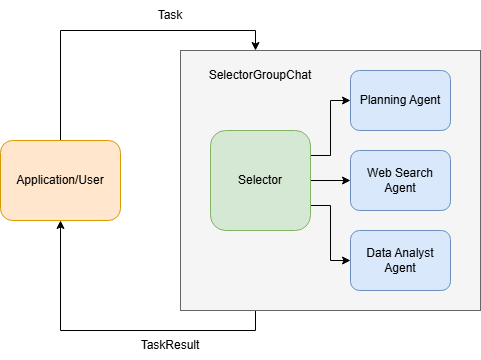

In [2]:
import os
from dotenv import load_dotenv


load_dotenv()
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")
tavily_tool = TavilySearch( 
    api_key=TAVILY_API_KEY,
    max_results=5
)

def search_web(query: str) -> str:
    """Search the web for a given query and return the top result."""
    print(f"Searching for: {query}")
    if not query:
        return "No query provided."
    results = tavily_tool.run(query)
    #print(f"Search results: {results}")
    if not results:
        return "No results found."
    if results:
        return results
    else:
        return "No results found."
    

    
def percentage_change(start: float, end: float) -> float:
    return ((end - start) / start) * 100


In [3]:
search_tool = FunctionTool(name="search_web_tool",description="Searches the web for information.",func=search_web)
percentage_change_tool= FunctionTool(name="percentage_change_tool",description="Calculates the percentage change between two numbers.",func=percentage_change)

In [4]:
planning_agent = AssistantAgent(
    "PlanningAgent",
    description="An agent for planning tasks, this agent should be the first to engage when given a new task.",
    model_client=model_client,
    system_message="""
    You are a planning agent.
    Your job is to break down complex tasks into smaller, manageable subtasks.
    Your team members are:
        WebSearchAgent: Searches for information
        DataAnalystAgent: Performs calculations

    You only plan and delegate tasks - you do not execute them yourself.

    When assigning tasks, use this format:
    1. <agent> : <task>

    After all tasks are complete, summarize the findings and end with "TERMINATE".
    """,
)

web_search_agent = AssistantAgent(
    "WebSearchAgent",
    description="An agent for searching information on the web.",
    tools=[search_tool],
    model_client=model_client,
    system_message="""
    You are a web search agent.
    Your only tool is search_tool - use it to find information.
    You make only one search call at a time.
    Once you have the results, you never do calculations based on them.
    """,
)

data_analyst_agent = AssistantAgent(
    "DataAnalystAgent",
    description="An agent for performing calculations.",
    model_client=model_client,
    tools=[percentage_change_tool],
    system_message="""
    You are a data analyst.
    Given the tasks you have been assigned, you should analyze the data and provide results using the tools provided.
    If you have not seen the data, ask for it.
    """,
)

In [5]:
selector_prompt = """Select an agent to perform task.

{roles}

Current conversation context:
{history}

Read the above conversation, then select an agent from {participants} to perform the next task.
Make sure the planner agent has assigned tasks before other agents start working.
Only select one agent.
"""


In [6]:
text_mention_termination = TextMentionTermination("TERMINATE")
max_messages_termination = MaxMessageTermination(max_messages=25)
termination = text_mention_termination | max_messages_termination


In [7]:
team = SelectorGroupChat(
    [planning_agent, web_search_agent, data_analyst_agent],
    model_client=model_client,
    termination_condition=termination,
    selector_prompt=selector_prompt,
    allow_repeated_speaker=True,  # Allow an agent to speak multiple turns in a row.
)


In [8]:
task = "Which Chennai Super Kings player hit the most sixes in 2025, and how did his batting average differ from his 2023 performance?"
# Use asyncio.run(...) if you are running this in a script.
await Console(team.run_stream(task=task))


---------- TextMessage (user) ----------
Which Chennai Super Kings player hit the most sixes in 2025, and how did his batting average differ from his 2023 performance?
---------- TextMessage (PlanningAgent) ----------
To gather the necessary information for your query, I will break down the task into smaller subtasks.

1. WebSearchAgent : Find out which Chennai Super Kings player hit the most sixes in the 2025 IPL season.
2. WebSearchAgent : Find the batting average of the top six-hitter from the Chennai Super Kings in 2025.
3. WebSearchAgent : Find the batting average of the same player from the 2023 IPL season.
4. DataAnalystAgent : Compare the batting averages from 2023 and 2025 to determine the difference.

Once these tasks are completed, I will summarize the findings.
---------- ToolCallRequestEvent (WebSearchAgent) ----------
Searching for: Chennai Super Kings player most sixes 2025 IPL
[FunctionCall(id='call_7xfQoRuhyEvdmOfC6EkzbgXn', arguments='{"query":"Chennai Super Kings pla

TaskResult(messages=[TextMessage(id='7b4109f4-1a40-4d42-8c31-092f6aed6fa4', source='user', models_usage=None, metadata={}, created_at=datetime.datetime(2025, 7, 13, 5, 59, 37, 462072, tzinfo=datetime.timezone.utc), content='Which Chennai Super Kings player hit the most sixes in 2025, and how did his batting average differ from his 2023 performance?', type='TextMessage'), TextMessage(id='300c75ac-c57b-4643-881d-19d8adfb44e7', source='PlanningAgent', models_usage=RequestUsage(prompt_tokens=143, completion_tokens=131), metadata={}, created_at=datetime.datetime(2025, 7, 13, 5, 59, 49, 764041, tzinfo=datetime.timezone.utc), content='To gather the necessary information for your query, I will break down the task into smaller subtasks.\n\n1. WebSearchAgent : Find out which Chennai Super Kings player hit the most sixes in the 2025 IPL season.\n2. WebSearchAgent : Find the batting average of the top six-hitter from the Chennai Super Kings in 2025.\n3. WebSearchAgent : Find the batting average of